In [1]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

In [ ]:
!pip install quantile-forest
!pip install dill

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
import sys
sys.path.append('..')
sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2

In [2]:
from src import tqf, gendata
from src.gendata import sig
from src.qmem import energy_distance, quantile

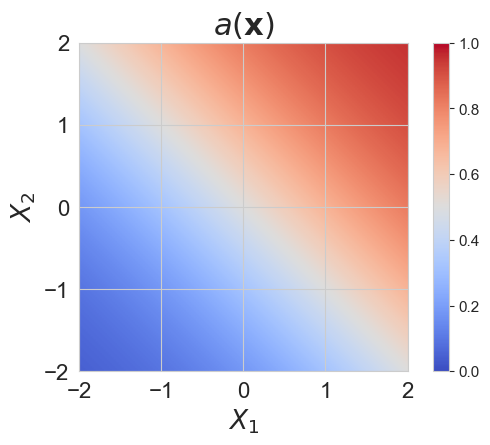

In [43]:
x = np.linspace(-2, 2, 200)
y = np.linspace(-2, 2, 200)
X, Y = np.meshgrid(x, y)

def sig_elementwise(x: np.ndarray) -> np.ndarray:
    Z = 1.5
    return 0.5 * (1. + np.tanh((Z * x) / 2.))

M = (X + Y) / 2
Z = sig_elementwise(M)

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(
    Z,
    extent=[x.min(), x.max(), y.min(), y.max()],
    origin="lower",
    cmap="coolwarm",
    aspect="equal",
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
cbar = fig.colorbar(im, cax=cax)
im.set_clim(0., 1.)
cbar.ax.tick_params(labelsize=11)
ax.set_xticks([-2, -1, 0, 1, 2]); ax.set_yticks([-2, -1, 0, 1, 2])
ax.tick_params(axis='both', labelsize=16)
ax.set_title(r"$a({\bf x})$", fontsize=22)
ax.set_xlabel(r'$X_1$', fontsize=19); ax.set_ylabel(r'$X_2$', fontsize=19)
plt.tight_layout()
# plt.savefig('fg_a_x_color.pdf', dpi=400)
plt.show()

In [3]:
p = 2
X, Y = gendata.create_r(size=20000, seed=465, num_features=p)
X.shape, Y.shape

((20000, 2), (20000, 2))

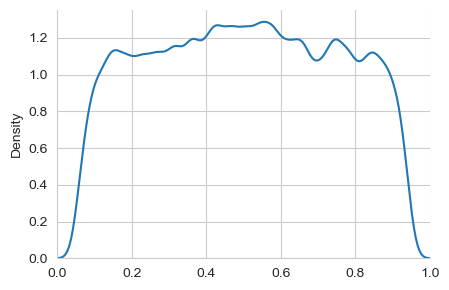

In [4]:
sns.displot(sig(X), kind='kde', height=3, aspect=1.5, bw_adjust=0.5)
plt.xlim(0, 1)
plt.show()

In [5]:
%%time
try:
    del model
    import gc
    gc.collect()
except:
    pass

model = tqf.TQF()
model.fit(X=X, Y=Y, seed=42, n_augment=15, n_jobs=8, T_rff=5, n_rot=10,
          qrf_params={'n_estimators': 50, 'min_samples_leaf': 300})
model.q_predictor.steps[1][1].feature_importances_

CPU times: total: 12min 36s
Wall time: 2min 8s


array([0.26021919, 0.28573878, 0.00153185, 0.0011458 , 0.00543862,
       0.00859567, 0.00148552, 0.00153095, 0.04291842, 0.11254826,
       0.00164532, 0.00114557, 0.02781132, 0.08478764, 0.00150788,
       0.00159657, 0.00180947, 0.00277728, 0.05521163, 0.09786813,
       0.00150099, 0.00118515])

In [8]:
np.array([tree.get_depth() for tree in model.q_predictor[1].estimators_])

array([20, 18, 17, 20, 19, 17, 19, 16, 17, 17, 19, 19, 17, 22, 18, 21, 18,
       20, 22, 18, 18, 18, 17, 19, 18, 19, 17, 17, 19, 18, 20, 19, 17, 19,
       18, 16, 19, 17, 18, 21, 19, 18, 18, 19, 18, 20, 19, 20, 18, 17])

In [9]:
np.array([tree.get_n_leaves() for tree in model.q_predictor[1].estimators_])

array([485, 481, 477, 488, 485, 475, 499, 474, 488, 491, 479, 489, 479,
       479, 491, 489, 485, 486, 492, 487, 479, 484, 486, 471, 487, 480,
       479, 485, 489, 486, 477, 479, 480, 480, 483, 484, 488, 477, 478,
       486, 484, 481, 480, 481, 495, 483, 484, 471, 483, 489])

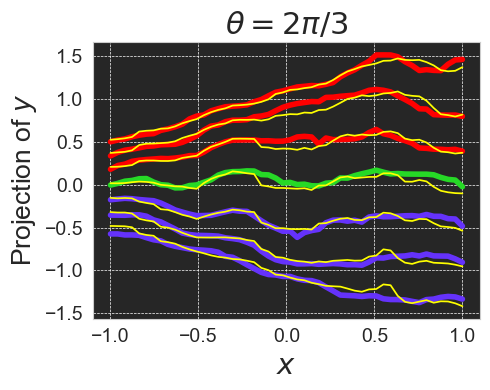

CPU times: total: 4.61 s
Wall time: 5.18 s


In [ ]:
%%time
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_facecolor((0.15, 0.15, 0.15))

theta = np.pi * 0.666
xs = np.linspace(-1., 1., 50)
qs = np.linspace(0.2, 0.8, 7)
K = len(qs)

_idx = lambda x: np.argsort(np.linalg.norm(X - np.array([x] * p), axis=1))[:500]
_dist = lambda x: np.linalg.norm(X[_idx(x)] - np.array([x] * p), axis=1)
_med = lambda x: np.median(_dist(x))
_weights = lambda x: np.exp(- (_dist(x) / _med(x))**2)
_Qx = np.asarray([quantile(
         model.y_scaler_whole.transform(Y[_idx(x)]) @ np.array([np.cos(theta), np.sin(theta)]), 
         weight=_weights(x), q=qs
     ) for x in xs])
for i in range(len(qs)):
    plt.plot(
        xs, _Qx[:, i],
        lw=4, color=(0.4, 0.2, 1, 0.99) if i < (K-1)//2 else 'r' if i > (K-1)//2 else (0.15, 0.85, 0.15)
    )

plt.plot(
    xs, model.y_scaler_1d.inverse_transform(
            model.predict_q(
                X_long=np.array([np.r_[[x] * p, model.expand_v(v=[np.cos(theta), np.sin(theta)], 
                                                               n_rot=model.n_rot)] for x in xs]),
                qs=qs
            ).reshape(-1, 1)
        ).reshape(len(xs), -1)
    , c='yellow', lw=1.25
)

plt.xlabel(r'$x$', fontsize=21)
plt.ylabel(r'Projection of $y$', fontsize=19)
plt.tick_params(labelsize=14)
plt.grid(color='w', ls='--', lw=0.5)
plt.title(r'$\theta=2\pi/3$'.format(theta), fontsize=22)
plt.tight_layout()
# plt.savefig('fg_r_x_dependence.pdf', dpi=400)
plt.show()

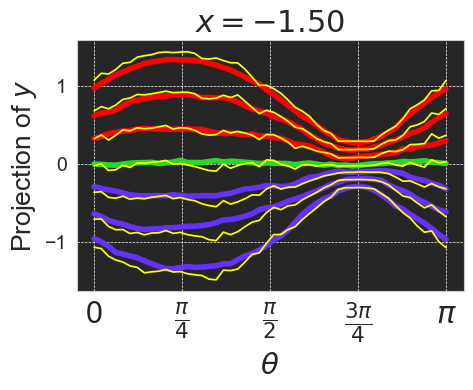

CPU times: total: 1.64 s
Wall time: 1.86 s


In [ ]:
%%time
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_facecolor((0.15, 0.15, 0.15))

theta_s = np.linspace(0., np.pi, 50)
x = - 1.5
qs = np.linspace(0.2, 0.8, 7)
K = len(qs)

_Qt = np.asarray([quantile(
         model.y_scaler_whole.transform(Y[_idx(x)]) @ np.array([np.cos(theta), np.sin(theta)]), 
         weight=_weights(x), q=qs
     ) for theta in theta_s])
for i in range(len(qs)):
    plt.plot(
        theta_s, _Qt[:, i],
        lw=4, color=(0.4, 0.2, 1, 0.99) if i < (K-1)//2 else 'r' if i > (K-1)//2 else (0.15, 0.85, 0.15)
    )

plt.plot(
    theta_s, model.y_scaler_1d.inverse_transform(
        model.predict_q(
            X_long=np.array([np.r_[[x] * p, model.expand_v(v=[np.cos(theta), np.sin(theta)], 
                                                           n_rot=model.n_rot)] for theta in theta_s]),
            qs=qs
        ).reshape(-1, 1)
    ).reshape(len(theta_s), len(qs))
    , c='yellow', lw=1.25
)

plt.xlabel(r'$\theta$', fontsize=21)
plt.ylabel(r'Projection of $y$', fontsize=19)
plt.tick_params(labelsize=14)
plt.xticks([0, np.pi/4, np.pi/2, np.pi/4*3, np.pi], ['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'], fontsize=22)
plt.grid(color='w', ls='--', lw=0.5)
plt.title(r'$x={:.2f}$'.format(x), fontsize=22)
plt.tight_layout()
# plt.savefig('fg_r_th_dependence.pdf', dpi=400)
plt.show()

In [12]:
def a2x(a: float):
    return np.log(a / (1. - a)) / 1.5

In [13]:
%%time
w_opt_all = []
points_all = []

for x in [a2x(a) for a in [0.1, 0.3, 0.5, 0.7, 0.9]]:
    w_opt, points = model.predict(seed=11, x=np.array([x] * p),
                                  n_qs=30, n_directions=30, n_ensemble=20,
                                  n_jobs=5, patience=3)
    w_opt_all += [w_opt]
    points_all += [points]

Initial search done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support points: 1800, selection rate: 90.0 %
Initial search done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support points: 1565, selection rate: 78.2 %
Initial search done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support points: 1960, selection rate: 98.0 %
Initial search done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.


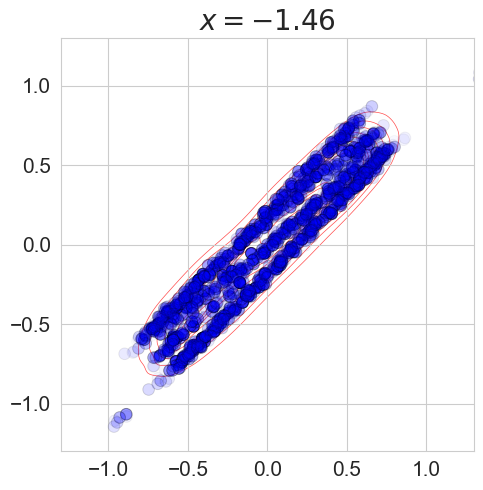

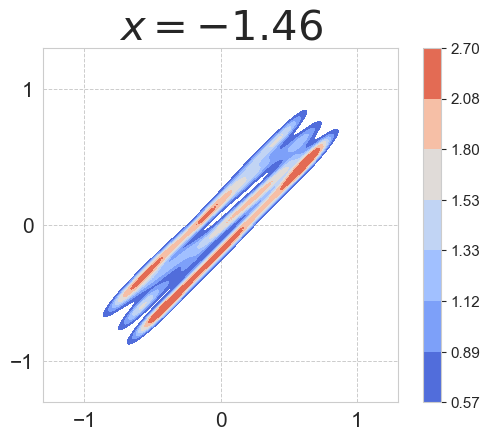

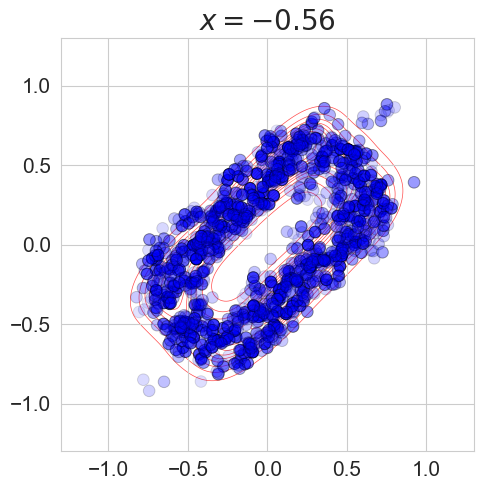

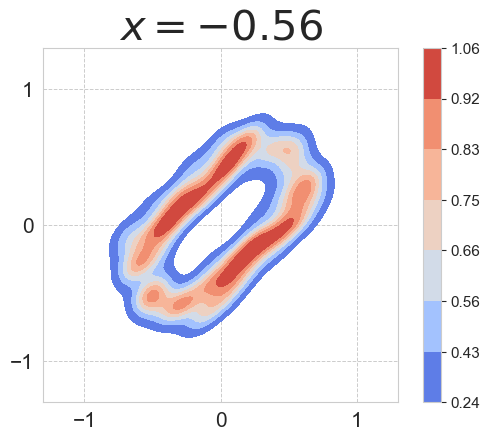

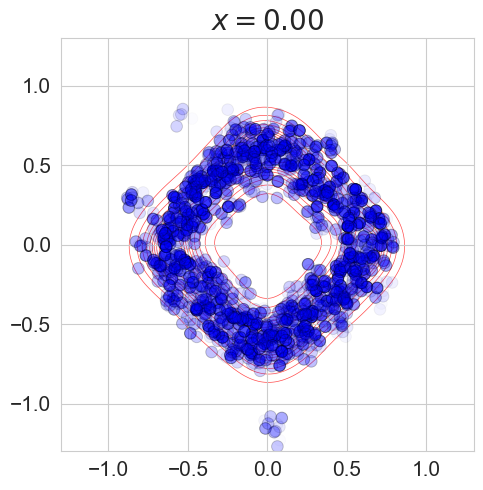

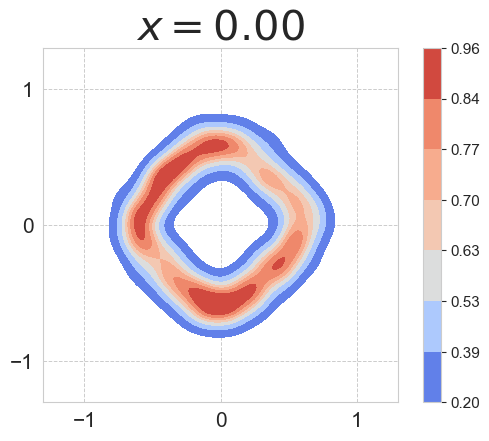

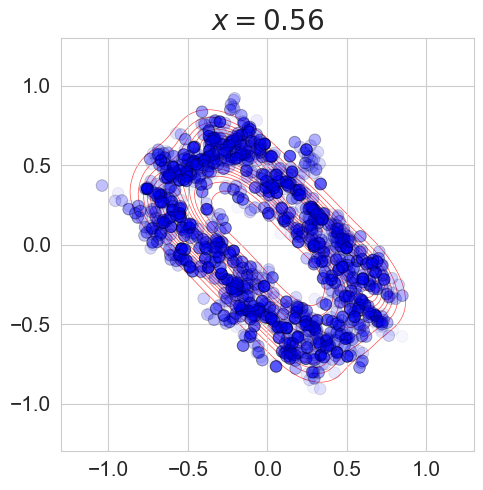

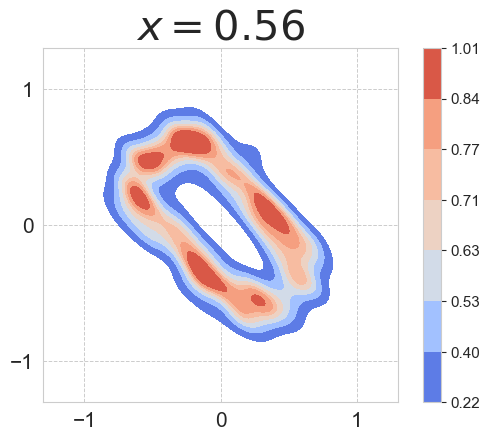

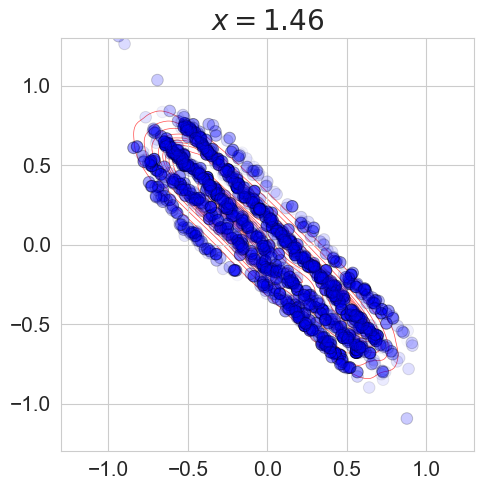

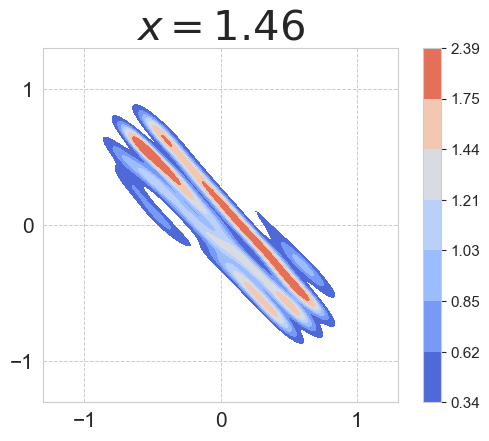

CPU times: total: 12.6 s
Wall time: 12.9 s


In [ ]:
%%time
for j, x in enumerate([a2x(a) for a in [0.1, 0.3, 0.5, 0.7, 0.9]]):

    w_opt, points = w_opt_all[j], points_all[j]
    
    #----------------------------------------------------------

    fig, ax = plt.subplots(figsize=(5, 5))
    Y_true = gendata.create_r_slice(a=sig(np.array([x] * p)), seed=5, size=3000)
    sns.kdeplot(
        data=pd.DataFrame(Y_true), x=0, y=1, thresh=0.1,
        levels=10, color='r', alpha=0.7, linewidths=0.5, zorder=0, ax=ax
    )
    sns.scatterplot(
        data=pd.DataFrame(points), x=0, y=1, c='b',
        s=70, edgecolor='k', zorder=1, ax=ax, alpha=w_opt/np.max(w_opt)
    )
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-1.3, 1.3); ax.set_ylim(-1.3, 1.3)
    plt.title(r'$x={:.2f}$'.format(x), fontsize=20)
    plt.tick_params(labelsize=15); plt.xlabel(None); plt.ylabel(None)
    plt.tight_layout()
    plt.show()

    #----------------------------------------------------------

    fig, ax = plt.subplots(figsize=(5, 5))
    sns.kdeplot(
        data=pd.DataFrame(points), weights=w_opt, levels=8,
        x=0, y=1, fill=True, zorder=1, ax=ax, bw_adjust=0.75, thresh=0.1, cmap='coolwarm'
    )
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-1.3, 1.3); ax.set_ylim(-1.3, 1.3)
    ax.grid(True, linewidth=0.7, ls='--')
    ax.set_xticks(np.arange(-1, 2, 1))
    ax.set_yticks(np.arange(-1, 2, 1))
    plt.title(r'$x={:.2f}$'.format(x), fontsize=30)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.25)
    im = ax.collections[0]
    cbar = fig.colorbar(im, cax=cax, format='%.2f')
    cbar.ax.tick_params(labelsize=11)
    
    ax.tick_params(axis='both', labelsize=15); ax.set_xlabel(None); ax.set_ylabel(None)
    plt.tight_layout()
    # plt.savefig('fg_r_{:.2f}.pdf'.format(x), dpi=400)
    plt.show()

# Comparison with varying n_rot

n_rot = 1

In [ ]:
%%time
NN = 2000
res_tqf = []

for (a, x) in [(a, a2x(a)) for a in [0.1, 0.2, 0.3, 0.4, 0.5]]:

    out = []

    for z in range(3):

        X, Y = gendata.create_r(size=20000, seed=z, num_features=p)
        try:
            del model
            import gc
            gc.collect()
        except:
            pass
        model = tqf.TQF()
        model.fit(X=X, Y=Y, seed=z, n_augment=15, n_jobs=4, T_rff=5, n_rot=1,
                  qrf_params={'n_estimators': 50, 'min_samples_leaf': 300})

        for j in range(3):
            print((z, j), end=' ')
            w_opt, points = model.predict(seed=j + 100 * z, x=np.array([x] * p), verbose=False,
                                          n_qs=30, n_directions=30, n_ensemble=20,
                                          n_jobs=10, patience=3)
            Y_true = gendata.create_r_slice(a=a, seed=j + 100 * z, size=NN)
            out.append(energy_distance(X=Y_true, Y=points, weight_Y=w_opt))

    res_tqf.append([a, np.mean(out), np.std(out)])

res_tqf = np.array(res_tqf)

(0, 0) (0, 1) (0, 2) (1, 0) (1, 1) (1, 2) (2, 0) (2, 1) (2, 2) (0, 0) (0, 1) (0, 2) (1, 0) (1, 1) (1, 2) (2, 0) (2, 1) (2, 2) (0, 0) (0, 1) (0, 2) (1, 0) (1, 1) (1, 2) (2, 0) (2, 1) (2, 2) (0, 0) (0, 1) (0, 2) (1, 0) (1, 1) (1, 2) (2, 0) (2, 1) (2, 2) (0, 0) (0, 1) (0, 2) (1, 0) (1, 1) (1, 2) (2, 0) (2, 1) (2, 2) CPU times: user 46min 42s, sys: 45.4 s, total: 47min 27s
Wall time: 32min 53s


In [ ]:
print(res_tqf)

[[0.1        0.06726443 0.02330259]
 [0.2        0.05471282 0.00972637]
 [0.3        0.04520987 0.01110967]
 [0.4        0.05376944 0.01240348]
 [0.5        0.0612594  0.01744248]]


n_rot = 5

In [ ]:
%%time
NN = 2000
res_tqf = []

for (a, x) in [(a, a2x(a)) for a in [0.1, 0.2, 0.3, 0.4, 0.5]]:

    out = []

    for z in range(3):

        X, Y = gendata.create_r(size=20000, seed=z, num_features=p)
        try:
            del model
            import gc
            gc.collect()
        except:
            pass
        model = tqf.TQF()
        model.fit(X=X, Y=Y, seed=z, n_augment=15, n_jobs=5, T_rff=5, n_rot=5,
                  qrf_params={'n_estimators': 50, 'min_samples_leaf': 300})

        for j in range(3):
            print((z, j), end=' ')
            w_opt, points = model.predict(seed=j + 100 * z, x=np.array([x] * p), verbose=False,
                                          n_qs=30, n_directions=30, n_ensemble=20,
                                          n_jobs=4, patience=3)
            Y_true = gendata.create_r_slice(a=a, seed=j + 100 * z, size=NN)
            out.append(energy_distance(X=Y_true, Y=points, weight_Y=w_opt))

    res_tqf.append([a, np.mean(out), np.std(out)])

res_tqf = np.array(res_tqf)

In [33]:
print(res_tqf)

[[0.1        0.04181028 0.01644345]
 [0.2        0.03710178 0.00534724]
 [0.3        0.04571387 0.0111045 ]
 [0.4        0.04461336 0.01001085]
 [0.5        0.04806546 0.0171409 ]]


n_rot = 10

In [ ]:
%%time
NN = 2000
res_tqf = []

for (a, x) in [(a, a2x(a)) for a in [0.1, 0.2, 0.3, 0.4, 0.5]]:

    out = []

    for z in range(3):

        X, Y = gendata.create_r(size=20000, seed=z, num_features=p)
        try:
            del model
            import gc
            gc.collect()
        except:
            pass
        model = tqf.TQF()
        model.fit(X=X, Y=Y, seed=z, n_augment=15, n_jobs=5, T_rff=5, n_rot=10,
                  qrf_params={'n_estimators': 50, 'min_samples_leaf': 300})

        for j in range(3):
            print((z, j), end=' ')
            w_opt, points = model.predict(seed=j + 100 * z, x=np.array([x] * p), verbose=False,
                                          n_qs=30, n_directions=30, n_ensemble=20,
                                          n_jobs=4, patience=3)
            Y_true = gendata.create_r_slice(a=a, seed=j + 100 * z, size=NN)
            out.append(energy_distance(X=Y_true, Y=points, weight_Y=w_opt))

    res_tqf.append([a, np.mean(out), np.std(out)])

res_tqf = np.array(res_tqf)

(0, 0) (0, 1) (0, 2) (1, 0) (1, 1) (1, 2) (2, 0) (2, 1) (2, 2) (0, 0) (0, 1) (0, 2) (1, 0) (1, 1) (1, 2) (2, 0) (2, 1) (2, 2) (0, 0) (0, 1) (0, 2) (1, 0) (1, 1) (1, 2) (2, 0) (2, 1) (2, 2) (0, 0) (0, 1) (0, 2) (1, 0) (1, 1) (1, 2) (2, 0) (2, 1) (2, 2) (0, 0) (0, 1) (0, 2) (1, 0) (1, 1) (1, 2) (2, 0) (2, 1) (2, 2) CPU times: user 3h 42min 24s, sys: 1min 9s, total: 3h 43min 34s
Wall time: 1h 12min 16s


In [70]:
print(res_tqf)

[[0.1        0.03601078 0.01352878]
 [0.2        0.03518283 0.00588099]
 [0.3        0.04007407 0.01308227]
 [0.4        0.04332773 0.01024882]
 [0.5        0.0514305  0.02233304]]


n_rot = 10 (averaged over 10 seeds)

In [ ]:
%%time
NN = 2000
res_tqf = []

for k, (a, x) in enumerate([(a, a2x(a)) for a in [0.1, 0.2, 0.3, 0.4, 0.5]]):

    out = []

    for z in range(10):
        
        print((k, z), end=' ')
        SEED = z + 100 * k
        X, Y = gendata.create_r(size=20000, seed=SEED, num_features=p)
        try:
            del model
            import gc
            gc.collect()
        except:
            pass
        model = tqf.TQF()
        model.fit(X=X, Y=Y, seed=SEED, n_augment=15, n_jobs=8, T_rff=5, n_rot=10,
                  qrf_params={'n_estimators': 50, 'min_samples_leaf': 300})

        w_opt, points = model.predict(seed=SEED, x=np.array([x] * p), verbose=False,
                                      n_qs=30, n_directions=30, n_ensemble=20,
                                      n_jobs=10, patience=3)
        Y_true = gendata.create_r_slice(a=a, seed=SEED, size=NN)
        out.append(energy_distance(X=Y_true, Y=points, weight_Y=w_opt))

    res_tqf.append([a, np.mean(out), np.std(out)])

res_tqf = np.array(res_tqf)

In [7]:
print(res_tqf)

[[0.1        0.03760459 0.00714879]
 [0.2        0.03343884 0.00614853]
 [0.3        0.03769066 0.00854856]
 [0.4        0.03921707 0.00629469]
 [0.5        0.04266575 0.01159762]]


n_rot = 15

In [39]:
%%time
NN = 2000
res_tqf = []

for (a, x) in [(a, a2x(a)) for a in [0.1, 0.2, 0.3, 0.4, 0.5]]:

    out = []

    for z in range(3):

        X, Y = gendata.create_r(size=20000, seed=z, num_features=p)
        try:
            del model
            import gc
            gc.collect()
        except:
            pass
        model = tqf.TQF()
        model.fit(X=X, Y=Y, seed=z, n_augment=15, n_jobs=5, T_rff=5, n_rot=15,
                  qrf_params={'n_estimators': 50, 'min_samples_leaf': 300})

        for j in range(3):
            print((z, j), end=' ')
            w_opt, points = model.predict(seed=j + 100 * z, x=np.array([x] * p), verbose=False,
                                          n_qs=30, n_directions=30, n_ensemble=20,
                                          n_jobs=10, patience=3)
            Y_true = gendata.create_r_slice(a=a, seed=j + 100 * z, size=NN)
            out.append(energy_distance(X=Y_true, Y=points, weight_Y=w_opt))

    res_tqf.append([a, np.mean(out), np.std(out)])

res_tqf = np.array(res_tqf)

(0, 0) (0, 1) (0, 2) (1, 0) (1, 1) (1, 2) (2, 0) (2, 1) (2, 2) (0, 0) (0, 1) (0, 2) (1, 0) (1, 1) (1, 2) (2, 0) (2, 1) (2, 2) (0, 0) (0, 1) (0, 2) (1, 0) (1, 1) (1, 2) (2, 0) (2, 1) (2, 2) (0, 0) (0, 1) (0, 2) (1, 0) (1, 1) (1, 2) (2, 0) (2, 1) (2, 2) (0, 0) (0, 1) (0, 2) (1, 0) (1, 1) (1, 2) (2, 0) (2, 1) (2, 2) CPU times: user 3h 44min 29s, sys: 1min 17s, total: 3h 45min 47s
Wall time: 1h 8min 57s


In [41]:
print(res_tqf)

[[0.1        0.03942661 0.01753952]
 [0.2        0.03808551 0.00447686]
 [0.3        0.04330271 0.01092287]
 [0.4        0.0453442  0.00999537]
 [0.5        0.05060941 0.01785146]]


# Comparison of methods

Oracle

In [48]:
%%time
NN = 2000
res_true = []

for n, a in enumerate(np.arange(0.1, 1, 0.1)):

    def ed(j: int) -> float:

        Y_true_1 = gendata.create_r_slice(a=a, seed=j + n * 200, size=NN)
        Y_true_2 = gendata.create_r_slice(a=a, seed=j + n * 200 + 10000, size=NN)

        return energy_distance(X=Y_true_1, Y=Y_true_2)

    out = Parallel(n_jobs=8)(delayed(ed)(j) for j in range(100))
    res_true.append([a, np.mean(out), np.std(out)])

res_true = np.array(res_true)
print(res_true)

[[0.1        0.02517965 0.00877328]
 [0.2        0.02684538 0.00796936]
 [0.3        0.02458365 0.00801463]
 [0.4        0.02561768 0.00775529]
 [0.5        0.02676957 0.00743104]
 [0.6        0.0263627  0.0082268 ]
 [0.7        0.02575481 0.00786093]
 [0.8        0.02693372 0.00922116]
 [0.9        0.02454912 0.00799859]]
CPU times: total: 5.33 s
Wall time: 18min 46s


Trivial point prediction

In [4]:
%%time
NN = 2000
res_point = []

for n, a in enumerate(np.arange(0.1, 1, 0.1)):

    def ed(j: int) -> float:

        Y_true_1 = gendata.create_r_slice(a=a, seed=j + n * 200, size=NN)
        Y_MEAN = np.mean(Y_true_1, axis=0, keepdims=True)

        return energy_distance(X=Y_true_1, Y=Y_MEAN)

    out = Parallel(n_jobs=8)(delayed(ed)(j) for j in range(100))
    res_point.append([a, np.mean(out), np.std(out)])

res_point = np.array(res_point)
print(res_point)

[[0.1        0.58557946 0.00504535]
 [0.2        0.60068397 0.00502704]
 [0.3        0.6193441  0.00306138]
 [0.4        0.63306808 0.00227679]
 [0.5        0.63810213 0.00132328]
 [0.6        0.63293297 0.00188068]
 [0.7        0.61909448 0.00310767]
 [0.8        0.60033851 0.00428006]
 [0.9        0.58608295 0.00512729]]
CPU times: total: 1.89 s
Wall time: 1min 45s


GMM (n=1)

In [64]:
%%time
NN = 2000
res_gm_1 = []

for n, a in enumerate(np.arange(0.1, 1, 0.1)):

    def ed(j: int) -> float:

        Y_true_1 = gendata.create_r_slice(a=a, seed=j + n * 200, size=NN)
        from sklearn.mixture import BayesianGaussianMixture
        gm = BayesianGaussianMixture(n_components=1, max_iter=1000, 
                                     random_state=j + n * 200).fit(Y_true_1)
        Y_gm, _ = gm.sample(n_samples=NN)
        return energy_distance(X=Y_true_1, Y=Y_gm)

    out = Parallel(n_jobs=8)(delayed(ed)(j) for j in range(100))
    res_gm_1.append([a, np.mean(out), np.std(out)])

res_gm_1 = np.array(res_gm_1)
print(res_gm_1)

[[0.1        0.07905647 0.00607028]
 [0.2        0.09012192 0.00726915]
 [0.3        0.10635907 0.00518049]
 [0.4        0.11804607 0.00500413]
 [0.5        0.12180243 0.00428686]
 [0.6        0.11748434 0.00459423]
 [0.7        0.1063733  0.00591008]
 [0.8        0.08904212 0.00595946]
 [0.9        0.07823721 0.00722602]]
CPU times: total: 5.17 s
Wall time: 19min 3s


GMM (n=2)

In [67]:
%%time
NN = 2000
res_gm_2 = []

for n, a in enumerate(np.arange(0.1, 1, 0.1)):

    def ed(j: int) -> float:

        Y_true_1 = gendata.create_r_slice(a=a, seed=j + n * 200, size=NN)
        from sklearn.mixture import BayesianGaussianMixture
        gm = BayesianGaussianMixture(n_components=2, max_iter=1000, 
                                     random_state=j + n * 200).fit(Y_true_1)
        Y_gm, _ = gm.sample(n_samples=NN)
        return energy_distance(X=Y_true_1, Y=Y_gm)

    out = Parallel(n_jobs=8)(delayed(ed)(j) for j in range(100))
    res_gm_2.append([a, np.mean(out), np.std(out)])

res_gm_2 = np.array(res_gm_2)
print(res_gm_2)

[[0.1        0.03549177 0.00492823]
 [0.2        0.05111185 0.00437097]
 [0.3        0.07175975 0.00373303]
 [0.4        0.08655397 0.0036933 ]
 [0.5        0.09352399 0.00400855]
 [0.6        0.08656173 0.00361347]
 [0.7        0.07162157 0.0036223 ]
 [0.8        0.05044999 0.00432261]
 [0.9        0.03554265 0.00532532]]
CPU times: total: 5.16 s
Wall time: 19min 38s


GMM (n=3)

In [148]:
%%time
NN = 2000
res_gm_3 = []

for n, a in enumerate(np.arange(0.1, 1, 0.1)):

    def ed(j: int) -> float:

        Y_true_1 = gendata.create_r_slice(a=a, seed=j + n * 200, size=NN)
        from sklearn.mixture import BayesianGaussianMixture
        gm = BayesianGaussianMixture(n_components=3, max_iter=1000, 
                                     random_state=j + n * 200).fit(Y_true_1)
        Y_gm, _ = gm.sample(n_samples=NN)
        return energy_distance(X=Y_true_1, Y=Y_gm)

    out = Parallel(n_jobs=8)(delayed(ed)(j) for j in range(100))
    res_gm_3.append([a, np.mean(out), np.std(out)])

res_gm_3 = np.array(res_gm_3)
print(res_gm_3)

[[0.1        0.02271952 0.00492921]
 [0.2        0.03991681 0.0044147 ]
 [0.3        0.05565588 0.00454976]
 [0.4        0.05496065 0.00401132]
 [0.5        0.05415811 0.00296702]
 [0.6        0.0545636  0.00404807]
 [0.7        0.0559884  0.0053293 ]
 [0.8        0.03864055 0.00329383]
 [0.9        0.02339454 0.00499633]]
CPU times: total: 5.84 s
Wall time: 19min 59s


Naive method: assume P(y_1, y_2|x) = P(y_1|x)P(y_2|x)

In [71]:
%%time
NN = 2000
res_marginal = []

for n, a in enumerate([0.1, 0.2, 0.3, 0.4, 0.5]):

    def ed(j: int) -> float:

        Y_true = gendata.create_r_slice(a=a, seed=j + n * 200, size=NN)
        Y_shuffled = Y_true.copy()
        Y_shuffled[:, 1] = np.random.default_rng(j + n * 200).permutation(Y_true[:, 1])

        return energy_distance(X=Y_true, Y=Y_shuffled)

    out = Parallel(n_jobs=8)(delayed(ed)(j) for j in range(100))
    res_marginal.append([a, np.mean(out), np.std(out)])

res_marginal = np.array(res_marginal)
print(res_marginal)

[[0.1        0.20537017 0.00500438]
 [0.2        0.16561329 0.00622382]
 [0.3        0.12740241 0.00584576]
 [0.4        0.09833564 0.00420086]
 [0.5        0.08682257 0.0026246 ]]
CPU times: total: 4.25 s
Wall time: 11min 9s


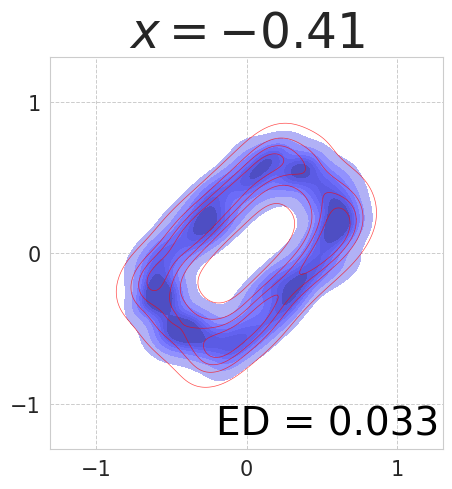

CPU times: user 8.7 s, sys: 16.6 ms, total: 8.72 s
Wall time: 4.81 s


In [81]:
%%time
for a, x in [(a, a2x(a)) for a in [0.35]]:

    print("x = {}".format(x))
    X, Y = gendata.create_r(size=20000, seed=0, num_features=p)
    try:
        del model
        import gc
        gc.collect()
    except:
        pass
    model = tqf.TQF()
    model.fit(X=X, Y=Y, seed=1, n_augment=15, n_jobs=2, T_rff=5, n_rot=10,
              qrf_params={'n_estimators': 50, 'min_samples_leaf': 300})
    w_opt, points = model.predict(seed=0, x=np.array([x] * p), verbose=False,
                                  n_qs=30, n_directions=30, n_ensemble=20,
                                  n_jobs=4, patience=3)
    
    # =========================================================== #
    
    fig, ax = plt.subplots(figsize=(5, 5))
    Y_true = gendata.create_r_slice(a=a, seed=7, size=NN)
    sns.kdeplot(
        data=pd.DataFrame(Y_true), x=0, y=1, thresh=0.1,
        levels=5, color='r', alpha=0.7, linewidths=0.5, zorder=2, ax=ax
    )
    sns.kdeplot(
        data=pd.DataFrame(points), weights=w_opt, levels=8,
        x=0, y=1, fill=True, zorder=1, ax=ax, bw_adjust=0.75, thresh=0.1, color='b'
    )
    
    Y_true = gendata.create_r_slice(a=a, seed=0, size=NN)
    ED = energy_distance(X=Y_true, Y=points, weight_Y=w_opt)
    ax.text(-0.2, -1.2, f'ED = {ED:.3f}', fontsize=28, color='k')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-1.3, 1.3); ax.set_ylim(-1.3, 1.3)
    ax.grid(True, linewidth=0.7, ls='--')
    ax.set_xticks(np.arange(-1, 2, 1))
    ax.set_yticks(np.arange(-1, 2, 1))
    ax.set_title(r'$x={:.2f}$'.format(x), fontsize=35)
    ax.tick_params(labelsize=15); ax.set_xlabel(None); ax.set_ylabel(None)
    plt.tight_layout()
    plt.savefig('fg_r_{:.2f}_.pdf'.format(x), dpi=400)
    plt.show()

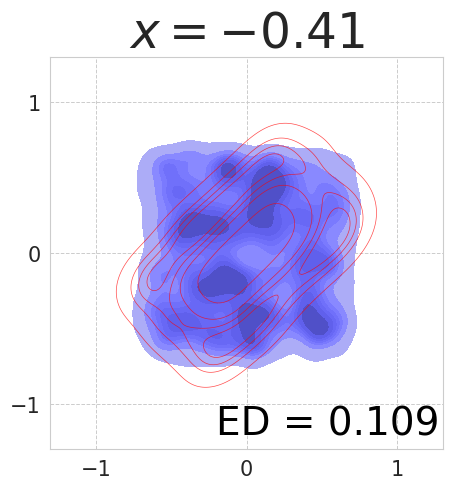

CPU times: user 8.58 s, sys: 12 ms, total: 8.6 s
Wall time: 4.88 s


In [80]:
%%time
for a, x in [(a, a2x(a)) for a in [0.35]]:
    
    Y_true = gendata.create_r_slice(a=a, seed=7, size=NN)
    
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.kdeplot(
        data=pd.DataFrame(Y_true), x=0, y=1, thresh=0.1,
        levels=5, color='r', alpha=0.7, linewidths=0.5, zorder=2, ax=ax
    )
    
    def shuffler(i: int):
        Y_shuffle = Y_true.copy()
        Y_shuffle[:, 1] = np.random.default_rng(i).permutation(Y_shuffle[:, 1])
        return Y_shuffle
    
    YY = np.random.RandomState(9).permutation(np.concatenate([shuffler(j) for j in range(10)], axis=0))[:NN]
    sns.kdeplot(
        data=pd.DataFrame(YY), levels=8,
        x=0, y=1, fill=True, zorder=1, ax=ax, bw_adjust=0.65, thresh=0.1, color='b'
    )

    ED = energy_distance(X=Y_true, Y=YY)
    ax.text(-0.2, -1.2, f'ED = {ED:.3f}', fontsize=28, color='k')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-1.3, 1.3); ax.set_ylim(-1.3, 1.3)
    ax.grid(True, linewidth=0.7, ls='--')
    ax.set_xticks(np.arange(-1, 2, 1))
    ax.set_yticks(np.arange(-1, 2, 1))
    plt.title(r'$x={:.2f}$'.format(x), fontsize=35)
    plt.tick_params(labelsize=15); plt.xlabel(None); plt.ylabel(None)
    plt.tight_layout()
    plt.savefig('fg_naive.pdf'.format(x), dpi=400)
    plt.show()

In [54]:
def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        
        # eigenvalues (asc), eigenvectors as COLUMNS
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])

        # principal axis = first eigenvector (associated with smallest eigval)
        v = eig_vecs[:, 0]                          # <-- 修正ポイント
        angle = np.degrees(np.arctan2(v[1], v[0]))  # radians -> degrees

        # Mahalanobis radius r = sqrt(2)  (≈63.2%等確率楕円)
        widths_heights = 2 * np.sqrt(2) * np.sqrt(eig_vals)  # [width, height]

        ell = mpl.patches.Ellipse(
            xy=means[n],
            width=widths_heights[0],
            height=widths_heights[1],
            angle=angle,               # 180+ は不要（向きが逆なら +180 でも同じ）
            edgecolor="black",
            facecolor="#56B4E9",
            alpha=weights[n] / max(weights)
        )
        ell.set_clip_box(ax.bbox)
        ax.add_patch(ell)

In [65]:
%%time
from sklearn.mixture import BayesianGaussianMixture
Y_true = gendata.create_r_slice(a=a, seed=7, size=NN)
gm = BayesianGaussianMixture(n_components=1, max_iter=1000, random_state=42).fit(Y_true)

CPU times: user 9.58 ms, sys: 0 ns, total: 9.58 ms
Wall time: 7.44 ms


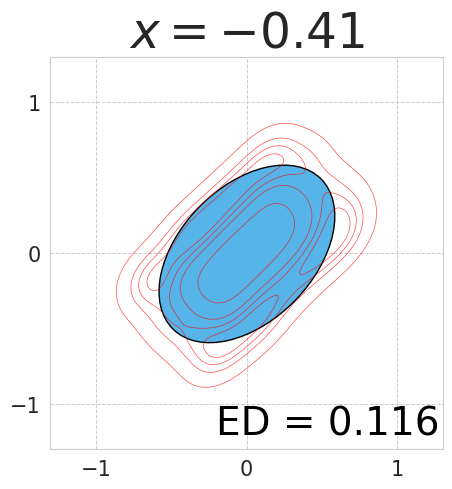

In [66]:
for a, x in [(a, a2x(a)) for a in [0.35]]:

    fig, ax = plt.subplots(figsize=(5, 5))
    Y_true = gendata.create_r_slice(a=a, seed=7, size=NN)

    sns.kdeplot(
        data=pd.DataFrame(Y_true), x=0, y=1, thresh=0.1,
        levels=5, color='r', alpha=0.7, linewidths=0.5, zorder=2, ax=ax
    )
    plot_ellipses(ax, gm.weights_, gm.means_, gm.covariances_)
    Y_gm, _ = gm.sample(n_samples=NN)
    ED = energy_distance(X=Y_true, Y=Y_gm)
    ax.text(-0.2, -1.2, f'ED = {ED:.3f}', fontsize=28, color='k')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-1.3, 1.3); ax.set_ylim(-1.3, 1.3)
    ax.set_xticks(np.arange(-1, 2, 1))
    ax.set_yticks(np.arange(-1, 2, 1))
    plt.tick_params(labelsize=15); plt.xlabel(None); plt.ylabel(None)
    plt.title(r'$x={:.2f}$'.format(x), fontsize=35)
    ax.grid(True, linewidth=0.7, ls='--')
    plt.tight_layout()
    plt.savefig('fg_Gauss_1.pdf'.format(x), dpi=400)
    plt.show()

In [67]:
%%time
from sklearn.mixture import BayesianGaussianMixture
Y_true = gendata.create_r_slice(a=a, seed=7, size=NN)
gm = BayesianGaussianMixture(n_components=2, max_iter=1000, random_state=42).fit(Y_true)

CPU times: user 669 ms, sys: 3.94 ms, total: 673 ms
Wall time: 340 ms


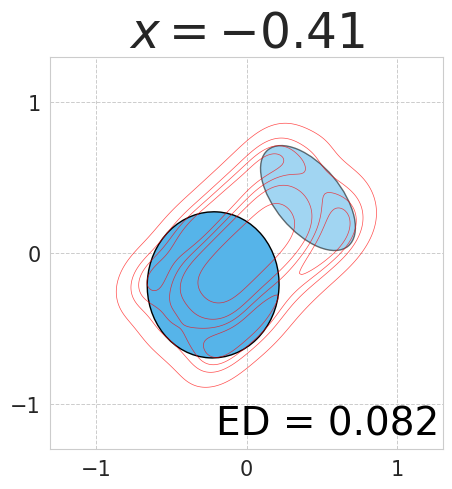

In [68]:
for a, x in [(a, a2x(a)) for a in [0.35]]:

    fig, ax = plt.subplots(figsize=(5, 5))
    Y_true = gendata.create_r_slice(a=a, seed=7, size=NN)

    sns.kdeplot(
        data=pd.DataFrame(Y_true), x=0, y=1, thresh=0.1,
        levels=5, color='r', alpha=0.7, linewidths=0.5, zorder=2, ax=ax
    )
    plot_ellipses(ax, gm.weights_, gm.means_, gm.covariances_)
    Y_gm, _ = gm.sample(n_samples=NN)
    ED = energy_distance(X=Y_true, Y=Y_gm)
    ax.text(-0.2, -1.2, f'ED = {ED:.3f}', fontsize=28, color='k')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-1.3, 1.3); ax.set_ylim(-1.3, 1.3)
    ax.set_xticks(np.arange(-1, 2, 1))
    ax.set_yticks(np.arange(-1, 2, 1))
    plt.tick_params(labelsize=15); plt.xlabel(None); plt.ylabel(None)
    plt.title(r'$x={:.2f}$'.format(x), fontsize=35)
    ax.grid(True, linewidth=0.7, ls='--')
    plt.tight_layout()
    plt.savefig('fg_Gauss_2.pdf'.format(x), dpi=400)
    plt.show()

In [69]:
%%time
from sklearn.mixture import BayesianGaussianMixture
Y_true = gendata.create_r_slice(a=a, seed=7, size=NN)
gm = BayesianGaussianMixture(n_components=3, max_iter=1000, random_state=42).fit(Y_true)

CPU times: user 178 ms, sys: 14 μs, total: 178 ms
Wall time: 92.9 ms


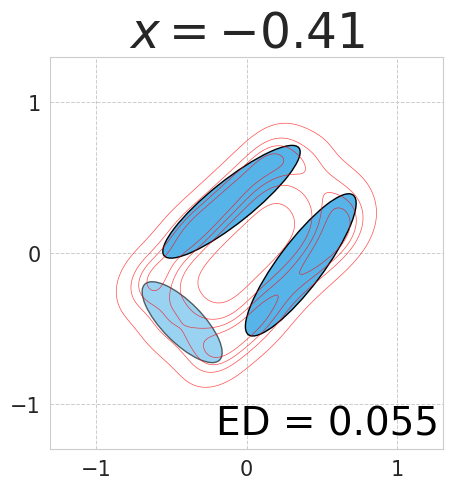

In [70]:
for a, x in [(a, a2x(a)) for a in [0.35]]:

    fig, ax = plt.subplots(figsize=(5, 5))
    Y_true = gendata.create_r_slice(a=a, seed=7, size=NN)

    sns.kdeplot(
        data=pd.DataFrame(Y_true), x=0, y=1, thresh=0.1,
        levels=5, color='r', alpha=0.7, linewidths=0.5, zorder=2, ax=ax
    )
    plot_ellipses(ax, gm.weights_, gm.means_, gm.covariances_)
    Y_gm, _ = gm.sample(n_samples=NN)
    ED = energy_distance(X=Y_true, Y=Y_gm)
    ax.text(-0.2, -1.2, f'ED = {ED:.3f}', fontsize=28, color='k')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-1.3, 1.3); ax.set_ylim(-1.3, 1.3)
    ax.set_xticks(np.arange(-1, 2, 1))
    ax.set_yticks(np.arange(-1, 2, 1))
    plt.tick_params(labelsize=15); plt.xlabel(None); plt.ylabel(None)
    plt.title(r'$x={:.2f}$'.format(x), fontsize=35)
    ax.grid(True, linewidth=0.7, ls='--')
    plt.tight_layout()
    plt.savefig('fg_Gauss_3.pdf'.format(x), dpi=400)
    plt.show()